In [302]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from skimage.feature import hog
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage.feature import local_binary_pattern

In [303]:
dataset_dir = f"Datasets/"

In [304]:
def loadData(arr, labelobject, target_size=(256, 256)):
    label = []
    strr = f"Datasets/{labelobject}/*.jpg"
    for file in glob.glob(strr):
        img = Image.open(file)
        img = img.resize(target_size)
        img = np.asarray(img)
        arr.append(img)
        label.append(labelobject)
    return arr, label


In [305]:
cat=[]
dog=[]

cat,label_cat = loadData(cat,'cats')
dog,label_dog = loadData(dog,'dogs')

In [307]:
cat = np.array(cat)
dog = np.array(dog)

X = np.concatenate((cat,dog),axis=0)
y = np.concatenate((label_cat,label_dog),axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [308]:
def preprocessing(arr, resize=False):
    arr_prep = []
    for i in range(len(arr)):
        img = arr[i]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if resize:
            img = cv2.resize(img, (64, 64))
        arr_prep.append(img)
    
    return arr_prep


In [309]:
x_train_prep = preprocessing(X_train, resize=True)
x_test_prep = preprocessing(X_test,resize=True)

### LBP

In [310]:
def extract_LBP(img):
    
    lbp = local_binary_pattern(img, 24,8, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(),bins=np.arange(0, 27),range=(0, 26))                   
    hist = hist.astype("float")                         
    hist /= (hist.sum() + (1e-7))
    return hist

In [311]:
def feature_extraction_LBP(arr):
    arr_feature=[]
    for i in range(np.shape(arr)[0]):
        arr_feature.append(extract_LBP(arr[i]))
    return arr_feature

In [312]:
x_train_feature_LBP = np.array(feature_extraction_LBP(x_train_prep))
x_test_feature_LBP = np.array(feature_extraction_LBP(x_test_prep))

### HOG

In [315]:
def extract_hog(images):
    features = []
    for img in images:
        if img.ndim == 3 and img.shape[2] == 3:
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray_img = img

        ftr, _ = hog(
            gray_img, 
            orientations=8, 
            pixels_per_cell=(10, 10),
            cells_per_block=(1, 1), 
            visualize=True
        )

        features.append(ftr)
    return np.array(features)

In [316]:
x_train_feature_HOG = extract_hog(x_train_prep)
x_test_feature_HOG = extract_hog(x_test_prep)

### SIFT

In [319]:
def extract_SIFT(images):
    sift = cv2.SIFT_create()
    features = []

    lengths = []

    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = sift.detectAndCompute(gray, None)
        
        if descriptors is None:
            descriptors = np.zeros((1, 128))

        lengths.append(len(descriptors))
        
        features.append(descriptors)
    max_length = max(lengths)

    # Pad deskripsi menjadi panjang maksimum
    for i in range(len(features)):
        current_length = lengths[i]
        if current_length < max_length:
            # Pad deskripsi dengan nilai nol
            padding = max_length - current_length
            pad_shape = (padding, features[i].shape[1])
            pad = np.zeros(pad_shape)
            features[i] = np.vstack((features[i], pad))

    # Gabungkan semua deskripsi ke dalam satu array
    return np.vstack(features)


In [320]:
x_train_feature_SIFT = extract_SIFT(X_train)
x_test_feature_SIFT = extract_SIFT(X_test)

### Evaluate LBP

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10, 50, 100, 200, 300],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(x_train_feature_LBP, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                         'n_estimators': [10, 50, 100, 200, 300]},
             verbose=2)

In [ ]:
print(grid_search.best_params_)

{'max_depth': 20, 'n_estimators': 100}


In [ ]:
grid_predictions = grid_search.predict(x_test_feature_LBP)

              precision    recall  f1-score   support

        cats       0.64      0.66      0.65       403
        dogs       0.64      0.62      0.63       397

    accuracy                           0.64       800
   macro avg       0.64      0.64      0.64       800
weighted avg       0.64      0.64      0.64       800



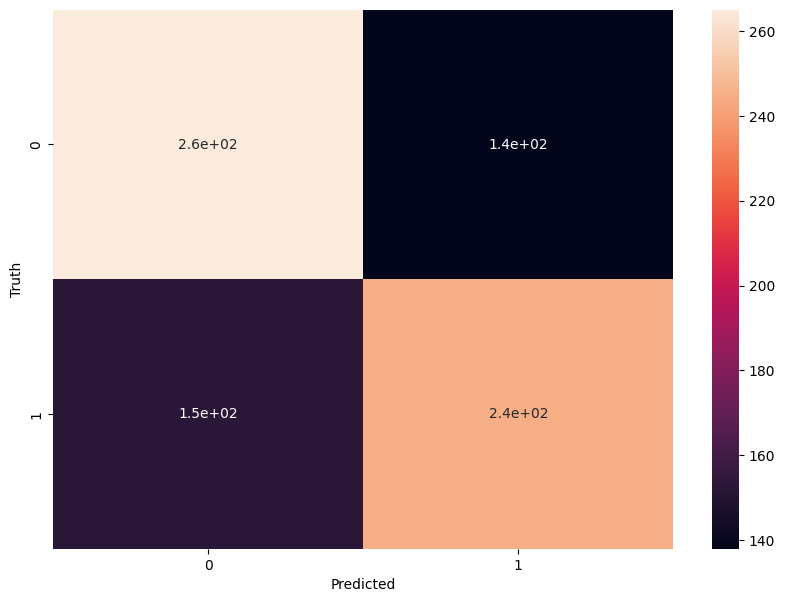

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, grid_predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(classification_report(y_test, grid_predictions))